Generate a PNG of binned (0.1 m/z) raw data for a single frame

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import sys

In [4]:
RT_LIMIT_LOWER = 4340
RT_LIMIT_UPPER = 4580

In [5]:
BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [6]:
CONVERTED_DATABASE_NAME

'/home/ubuntu/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [7]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER), db_conn)
db_conn.close()

In [8]:
df.head()

,frame_id,retention_time_secs
0,40408,4340.019894
1,40409,4340.127084
2,40410,4340.233855
3,40411,4340.340330
4,40412,4340.446655


In [9]:
RAW_FRAME_ID = 40410

In [101]:
MZ_MIN = 100.0
MZ_MAX = 1700.0
MZ_BIN_WIDTH = 0.1
MZ_BINS = int((MZ_MAX-MZ_MIN)/MZ_BIN_WIDTH)
SCAN_MIN = 1
SCAN_MAX = 910

In [102]:
MZ_BINS

16000

In [103]:
height = SCAN_MAX
width = MZ_BINS

In [104]:
im_array = np.zeros([height, width, 3], dtype=np.uint8)  # container for the image

Populate the image array with points from the raw frame

In [105]:
# load the raw frame points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(RAW_FRAME_ID), db_conn)
db_conn.close()

In [106]:
len(raw_points_df)

7953

In [107]:
intensity_array = np.zeros([height, width], dtype=np.uint16)  # scratchpad for the intensity value prior to image conversion
for point_idx in range(len(raw_points_df)):
    point_df = raw_points_df.iloc[point_idx]
    mz = point_df.mz
    scan = int(point_df.scan)
    if (mz >= MZ_MIN) and (mz <= MZ_MAX) and (scan >= SCAN_MIN) and (scan <= SCAN_MAX):
        mz_array_idx = int((mz-MZ_MIN)/MZ_BIN_WIDTH)
        scan_array_idx = scan-1
        intensity = int(point_df.intensity)
        intensity_array[scan_array_idx,mz_array_idx] += intensity

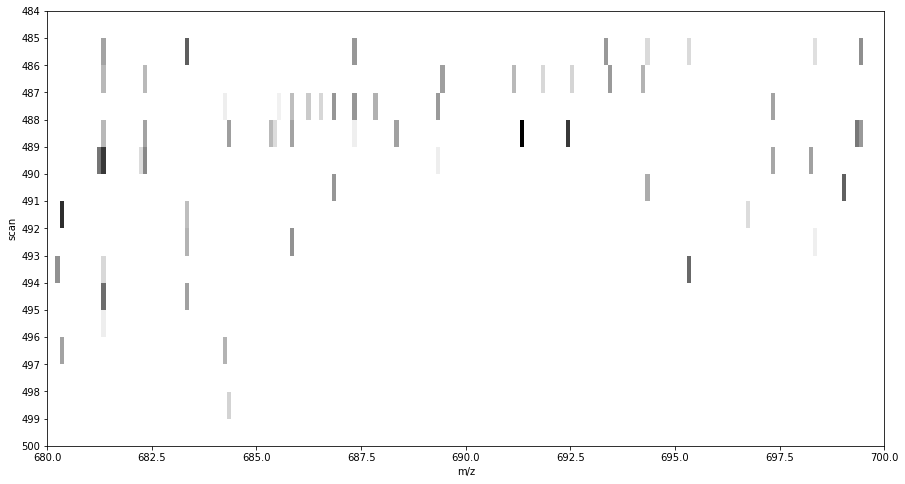

In [130]:
scan_lower = 484
scan_upper = 500
mz_actual_lower = 680.0
mz_actual_upper = 700.0

from matplotlib import colors, cm, pyplot as plt
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
mz_idx_lower = int((mz_actual_lower-MZ_MIN)/MZ_BIN_WIDTH)
mz_idx_upper = int((mz_actual_upper-MZ_MIN)/MZ_BIN_WIDTH)
plt.yticks(np.arange(scan_lower, scan_upper+1, dtype=np.int))
plt.xlabel('m/z')
plt.ylabel('scan')
plt.margins(0.06)
p = plt.imshow(intensity_array[scan_lower:scan_upper,mz_idx_lower:mz_idx_upper], cmap=plt.get_cmap('gist_yarg'), interpolation='none', aspect='auto', extent=[mz_actual_lower,mz_actual_upper,scan_upper,scan_lower])